<a href="https://colab.research.google.com/github/anmolsabharwal/RedDevils/blob/master/RD_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Main Libraries**

In [90]:
#importing Important libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from google.colab import drive
import datetime
import plotly.figure_factory as ff
 
 
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Establishing connection to .db file ***

In [91]:
#connection to .db file
gws = sqlite3.connect('/content/drive/My Drive/fpl.db')
gws = pd.read_sql_query("SELECT * FROM gw",gws)
gws.tail()


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
88499,Youri Tielemans,0,0,20,0,24.5,448,342,4,0,5.7,20.2,2020-07-12T18:00:00Z,90,3,0,0,0,0,44,0,290364,1,4,12,2,-1468,3543,5011,61,FALSE,0,149
88500,Yves Bissouma,0,0,8,0,1.9,53,343,5,0,0.7,5.4,2020-07-11T19:00:00Z,90,11,0,0,0,0,44,0,1910,5,0,0,1,50,117,67,50,TRUE,1,149
88501,Zech Medley,0,0,0,0,0,636,348,0,0,0,0,2020-07-12T15:30:00Z,0,17,0,0,0,0,44,0,1831,1,2,0,0,167,316,149,40,FALSE,0,149
88502,Çaglar Söyüncü,0,0,5,0,0.8,164,342,4,0,1,7.4,2020-07-12T18:00:00Z,66,3,0,0,0,1,44,0,1253775,1,4,2,-3,32374,51603,19229,50,FALSE,0,149
88503,Ørjan Nyland,0,0,0,0,0,27,341,0,0,0,0,2020-07-12T13:15:00Z,0,7,0,0,0,0,44,0,31410,0,2,0,0,-1673,413,2086,43,TRUE,0,149


In [92]:
gws.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'gw'],
      dtype='object')

**Converting the datatypes of columns**


In [93]:
#converting the datatypes of columns
gws=gws.astype({'name':'category','assists':int, 'bonus':int, 'bps':int, 'clean_sheets':int,
       'creativity':float,'element':int,'goals_conceded':int,
       'goals_scored':int, 'ict_index':float, 'influence':float,'minutes':int, 'opponent_team':int, 'own_goals':int,'penalties_missed':int, 'penalties_saved':int,
       'red_cards':int, 'round':int, 'saves':int, 'selected':int,
        # 'team_a_score':int, 'team_h_score':int,
        'threat':float,
       'total_points':int, 'transfers_balance':int, 'transfers_in':int, 'transfers_out':int,
       'value':int, 'yellow_cards':int,'gw':int})

**Cheking for null values**


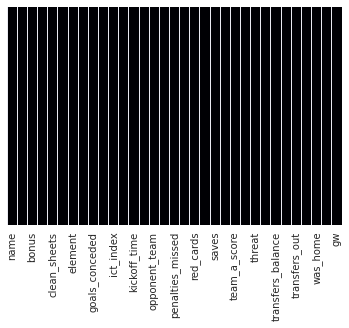

In [94]:
# cheking for null values
sns.set_style('dark')
sns.heatmap(gws.isnull(),yticklabels=False,cbar=False,cmap='inferno')

**Assigning id to each specific player**

In [95]:
#assigning id to each specific player
gws = gws.assign(id=(gws['name']).astype('category').cat.codes)


In [96]:
# gws= gws[gws['minutes'] > 0] 


**A function to decide the fixture difficulty ratio based on the position of the opponent team**

In [97]:
# a function to decide the fixture difficulty ratio based on the position of the opponent team
def fd(x):
  x=int(x)
  if x<=6:
    return '3'
  elif x>6 and x<=14:
    return '1'
  else:
    return '2'

In [98]:
gws.rename(columns={'opponent_team':'fdr'},inplace=True)


In [99]:
gws['fdr']=gws['fdr'].apply(fd).astype(float)


In [100]:
gws['kickoff_time']=pd.to_datetime(gws['kickoff_time'])

In [101]:
gws['kickoff_time'] = gws.kickoff_time.dt.hour


**Divided the kickoff time into 3 categories**



In [102]:
#divind the kickoff time into 3 categories 
def time(x):
  x=int(x)
  if x>8 and x<=12:
    return '0'
  elif x>12 and x<=18:
    return '1'
  else:
    return '2'

In [103]:
gws['kickoff_time']=gws['kickoff_time'].apply(time).astype(float)
gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id
0,Aaron Cresswell,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,55,FALSE,0,1,1
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,1,0,13918,1,1,0.0,1,0,0,0,60,TRUE,0,1,2
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,1,0,163170,4,3,23.0,2,0,0,0,80,TRUE,0,1,5
3,Abdoulaye Doucour�,0,0,0,0,0.0,482,7,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,1,0,1051,1,1,0.0,0,0,0,0,50,FALSE,0,1,11
4,Abdul Rahman Baba,0,0,0,0,0.0,80,10,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,1,0,1243,1,2,0.0,0,0,0,0,55,TRUE,0,1,12
5,Abel Hern�ndez,1,0,10,0,12.2,163,4,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,1,0,26039,1,2,30.0,5,0,0,0,60,TRUE,0,1,13
6,Adama Diomande,0,2,29,0,16.8,164,4,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,1,0,38151,1,2,45.0,8,0,0,0,45,TRUE,0,1,29
7,Adam Clayton,0,0,6,0,2.2,283,6,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,1,0,17663,1,1,9.0,2,0,0,0,45,TRUE,0,1,17
8,Adam Federici,0,0,0,0,0.0,30,9,0,0,0.0,0.0,0.0,0,1.0,0,0,0,0,1,0,4315,3,1,0.0,0,0,0,0,45,TRUE,0,1,18
9,Adam Forshaw,0,0,3,0,1.3,286,6,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,1,0,2723,1,1,0.0,1,0,0,0,45,TRUE,1,1,19


**Setting up the 'was_home' column to create binary attributes**


In [104]:
# setting up the 'was_home' column to create binary attributes
def was_home(a):
  a=a.upper()
  if a=="FALSE":
    #print('Away')
    return str('Away')
  else:
    #print('Home')
    return str('Home')

In [105]:
gws['home']=gws['was_home'].apply(was_home)

**Feature engineered variables based on Home and away performances of a player for further analysis**

In [106]:
gws['Away Points'] = np.where(gws['home'] == 'Home', gws['total_points'] * 0,gws['total_points'])
gws['Home Points'] = np.where(gws['home'] == 'Away', gws['total_points'] * 0,gws['total_points'])

gws['Away Influence'] = np.where(gws['home'] == 'Home', gws['influence'] * 0,gws['influence'])
gws['Home Influence'] = np.where(gws['home'] == 'Away', gws['influence'] * 0,gws['influence'])

gws['Away Goals'] = np.where(gws['home'] == 'Home', gws['goals_scored'] * 0,gws['goals_scored'])
gws['Home Goals'] = np.where(gws['home'] == 'Away', gws['goals_scored'] * 0,gws['goals_scored'])

gws['Away Saves'] = np.where(gws['home'] == 'Home', gws['saves'] * 0,gws['saves'])
gws['Home Saves'] = np.where(gws['home'] == 'Away', gws['saves'] * 0,gws['saves'])

gws['Away Creativity'] = np.where(gws['home'] == 'Home', gws['creativity'] * 0,gws['creativity'])
gws['Home Creativity'] = np.where(gws['home'] == 'Away', gws['creativity'] * 0,gws['creativity'])

gws['Away ICT'] = np.where(gws['home'] == 'Home', gws['ict_index'] * 0,gws['ict_index'])
gws['Home ICT'] = np.where(gws['home'] == 'Away', gws['ict_index'] * 0,gws['ict_index'])

gws['Away Bonus'] = np.where(gws['home'] == 'Home', gws['bonus'] * 0,gws['bonus'])
gws['Home Bonus'] = np.where(gws['home'] == 'Away', gws['bonus'] * 0,gws['bonus'])

gws['Away Clean Sheets'] = np.where(gws['home'] == 'Home', gws['clean_sheets'] * 0,gws['clean_sheets'])
gws['Home Clean Sheets'] = np.where(gws['home'] == 'Away', gws['clean_sheets'] * 0,gws['clean_sheets'])

gws['Away Penalties Saved'] = np.where(gws['home'] == 'Home', gws['penalties_saved'] * 0,gws['penalties_saved'])
gws['Home Penalties Saved'] = np.where(gws['home'] == 'Away', gws['penalties_saved'] * 0,gws['penalties_saved'])

gws['Away Goals Conceded'] = np.where(gws['home'] == 'Home', gws['goals_conceded'] * 0,gws['goals_conceded'])
gws['Home Goals Conceded'] = np.where(gws['home'] == 'Away', gws['goals_conceded'] * 0,gws['goals_conceded'])

gws['Away Assists'] = np.where(gws['home'] == 'Home', gws['assists'] * 0,gws['assists'])
gws['Home Assists'] = np.where(gws['home'] == 'Away', gws['assists'] * 0,gws['assists'])

gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists
0,Aaron Cresswell,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,55,FALSE,0,1,1,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,1,0,13918,1,1,0.0,1,0,0,0,60,TRUE,0,1,2,Home,0,1,0.0,8.2,0,0,0,0,0.0,0.3,0.0,0.9,0,0,0,0,0,0,0,0,0,0
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,1,0,163170,4,3,23.0,2,0,0,0,80,TRUE,0,1,5,Home,0,2,0.0,2.2,0,0,0,0,0.0,4.9,0.0,3.0,0,0,0,0,0,0,0,3,0,0
3,Abdoulaye Doucour�,0,0,0,0,0.0,482,7,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,1,0,1051,1,1,0.0,0,0,0,0,50,FALSE,0,1,11,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
4,Abdul Rahman Baba,0,0,0,0,0.0,80,10,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,1,0,1243,1,2,0.0,0,0,0,0,55,TRUE,0,1,12,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
5,Abel Hern�ndez,1,0,10,0,12.2,163,4,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,1,0,26039,1,2,30.0,5,0,0,0,60,TRUE,0,1,13,Home,0,5,0.0,14.4,0,0,0,0,0.0,12.2,0.0,5.7,0,0,0,0,0,0,0,1,0,1
6,Adama Diomande,0,2,29,0,16.8,164,4,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,1,0,38151,1,2,45.0,8,0,0,0,45,TRUE,0,1,29,Home,0,8,0.0,45.2,0,1,0,0,0.0,16.8,0.0,10.7,0,2,0,0,0,0,0,1,0,0
7,Adam Clayton,0,0,6,0,2.2,283,6,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,1,0,17663,1,1,9.0,2,0,0,0,45,TRUE,0,1,17,Home,0,2,0.0,3.2,0,0,0,0,0.0,2.2,0.0,1.4,0,0,0,0,0,0,0,1,0,0
8,Adam Federici,0,0,0,0,0.0,30,9,0,0,0.0,0.0,0.0,0,1.0,0,0,0,0,1,0,4315,3,1,0.0,0,0,0,0,45,TRUE,0,1,18,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
9,Adam Forshaw,0,0,3,0,1.3,286,6,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,1,0,2723,1,1,0.0,1,0,0,0,45,TRUE,1,1,19,Home,0,1,0.0,2.0,0,0,0,0,0.0,1.3,0.0,0.3,0,0,0,0,0,0,0,1,0,0


**Dropping columns that are not required**


In [107]:
#dropping columns that are not required
gws.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [108]:
gws['value']=gws['value']*0.1



**A fucntion to put the points into the bins. This is where the business problem is convereted from a regression to a classification problem**


In [109]:
# a fucntion to put the points into the bins. This is where the business problem is convereted from a regression to a classification problem
def points(x):
  if x<8:
    return 0
  # elif x==2:
  #   return 2
  # elif x>2 and x<7:
  #   return 3
  else:
    return 1


In [110]:
gws['points']=gws['total_points'].apply(points)
gws1=gws.copy()
gws1.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points
0,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,0,14023,0.0,0,5.5,0,1,1,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,1,2,Home,0,1,0.0,8.2,0,0,0,0,0.0,0.3,0.0,0.9,0,0,0,0,0,0,0,0,0,0,0
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,1,5,Home,0,2,0.0,2.2,0,0,0,0,0.0,4.9,0.0,3.0,0,0,0,0,0,0,0,3,0,0,0
3,Abdoulaye Doucour�,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,1051,0.0,0,5.0,0,1,11,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0
4,Abdul Rahman Baba,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,1243,0.0,0,5.5,0,1,12,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
# point=pd.get_dummies(gws1['points'])
# gws1=pd.concat([gws1,point],axis=1)
# gws1.head()

**Distribution of each class of the dependent variable**

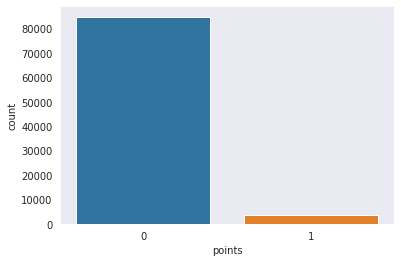

In [112]:
sns.countplot(gws1['points'])

**Creating lags for different attributes**


In [113]:
#creating lags for different attributes

gws1['Last_Week_Points'] = gws1.groupby(['id'])['total_points'].shift().astype(float)
# gws1['Last_2_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(2).astype(float)
#gws1['Last_3_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(3).astype(float)
#gws1['Last_4_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(4).astype(float)



gws1['Last_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift().astype(float)
# gws1['Last_2_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(2).astype(float)
#gws1['Last_3_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(3).astype(float)


gws1['Last_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift().astype(float)
# gws1['Last_2_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(2).astype(float)
# #gws1['Last_3_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(3).astype(float)


gws1['Last_Week_BPS'] = gws1.groupby(['id'])['bps'].shift().astype(float)
# gws1['Last_2_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(2).astype(float)
#gws1['Last_3_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(3).astype(float)


gws1['Last_Week_Assists'] = gws1.groupby(['id'])['assists'].shift().astype(float)
# gws1['Last_2_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(2).astype(float)
#gws1['Last_3_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(3).astype(float)


gws1['Last_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift().astype(float)
# gws1['Last_2_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(2).astype(float)
#gws1['Last_3_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(3).astype(float)


gws1['Last_Week_Influence'] = gws1.groupby(['id'])['influence'].shift().astype(float)
# gws1['Last_2_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(2).astype(float)
#gws1['Last_3_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(3).astype(float)


gws1['Last_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift().astype(float)
# gws1['Last_2_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(2).astype(float)
#gws1['Last_3_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(3).astype(float)


gws1['Last_Week_Threat'] = gws1.groupby(['id'])['threat'].shift().astype(float)
# gws1['Last_2_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(2).astype(float)
# #gws1['Last_3_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(3).astype(float)


gws1['Last_Week_Selected'] = gws1.groupby(['id'])['selected'].shift().astype(float)
# gws1['Last_2_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(2).astype(float)
#gws1['Last_3_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(3).astype(float)


gws1['Last_Week_Value'] = gws1.groupby(['id'])['value'].shift().astype(float)
# gws1['Last_2_Week_Value'] = gws1.groupby(['id'])['value'].shift(2).astype(float)
# gws1['Last_3_Week_Value'] = gws1.groupby(['id'])['value'].shift(3).astype(float)


gws1['Last_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift().astype(float)
# gws1['Last_2_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(2).astype(float)
# #gws1['Last_3_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(3).astype(float)



gws1['Last_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift().astype(float).astype(float)
# gws1['Last_2_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
# gws1['Last_3_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


gws1['Last_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift().astype(float)
# gws1['Last_2_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#gws1['Last_3_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(3).astype(float)


gws1['Last_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift().astype(float)
# gws1['Last_2_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#gws1['Last_3_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# gws1['Last_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift().astype(float)
# gws1['Last_2_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# gws1['Last_3_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(3).astype(float)


gws1['Last_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift().astype(float)
# gws1['Last_2_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(2).astype(float)
# gws1['Last_3_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(3).astype(float)


gws1['Last_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift().astype(float)
# gws1['Last_2_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# gws1['Last_3_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(3).astype(float)


gws1['Last_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift().astype(float)
# gws1['Last_2_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(2).astype(float)


gws1['Last_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift().astype(float)
# gws1['Last_2_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(2).astype(float)
# gws1['Last_3_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(3).astype(float)


gws1['Last_Week_Saves'] = gws1.groupby(['id'])['saves'].shift()
# gws1['Last_2_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(2)
#gws1['Last_3_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(3)


gws1['Last_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift()
# gws1['Last_2_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(2)
# gws1['Last_3_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(3)


# gws1['Last_Week_Home'] = gws1.groupby(['id'])['home'].shift()
# gws1['Last_2_Week_Home'] = gws1.groupby(['id'])['home'].shift(2)
# gws1['Last_3_Week_Home'] = gws1.groupby(['id'])['home'].shift(3)


gws1.head(100)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Last_Week_Points,Last_Week_Goals,Last_Week_ICT,Last_Week_BPS,Last_Week_Assists,Last_Week_Bonus,Last_Week_Influence,Last_Week_Minutes_Played,Last_Week_Threat,Last_Week_Selected,Last_Week_Value,Last_Week_Creativity,Last_Week_FDR,Last_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_Week_Own_Goals,Last_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_Week_Red_Cards,Last_Week_Saves,Last_Week_Yellow_Cards
0,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,0,14023,0.0,0,5.5,0,1,1,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,1,2,Home,0,1,0.0,8.2,0,0,0,0,0.0,0.3,0.0,0.9,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,1,5,Home,0,2,0.0,2.2,0,0,0,0,0.0,4.9,0.0,3.0,0,0,0,0,0,0,0,3,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdoulaye Doucour�,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,1051,0.0,0,5.0,0,1,11,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Abdul Rahman Baba,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,1243,0.0,0,5.5,0,1,12,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Abel Hern�ndez,1,0,10,0,12.2,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,0,26039,30.0,5,6.0,0,1,13,Home,0,5,0.0,14.4,0,0,0,0,0.0,12.2,0.0,5.7,0,0,0,0,0,0,0,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Adama Diomande,0,2,29,0,16.8,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,0,38151,45.0,8,4.5,0,1,29,Home,0,8,0.0,45.2,0,1,0,0,0.0,16.8,0.0,10.7,0,2,0,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adam Clayton,0,0,6,0,2.2,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,0,17663,9.0,2,4.5,0,1,17,Home,0,2,0.0,3.2,0,0,0,0,0.0,2.2,0.0,1.4,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Adam Federici,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0,1.0,0,0,0,0,0,4315,0.0,0,4.5,0,1,18,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Adam Forshaw,0,0,3,0,1.3,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,0,2723,0.0,1,4.5,1,1,19,Home,0,1,0.0,2.0,0,0,0,0,0.0,1.3,0.0,0.3,0,0,0,0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Creating binary attributes for was_home**


In [114]:
#creating binary attributes for was_home

home=pd.get_dummies(gws1['home'])
gws1=pd.concat([gws1,home],axis=1)
gws1.head()


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Last_Week_Points,Last_Week_Goals,Last_Week_ICT,Last_Week_BPS,Last_Week_Assists,Last_Week_Bonus,Last_Week_Influence,Last_Week_Minutes_Played,Last_Week_Threat,Last_Week_Selected,Last_Week_Value,Last_Week_Creativity,Last_Week_FDR,Last_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_Week_Own_Goals,Last_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_Week_Red_Cards,Last_Week_Saves,Last_Week_Yellow_Cards,Away,Home
0,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,0,14023,0.0,0,5.5,0,1,1,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,1,2,Home,0,1,0.0,8.2,0,0,0,0,0.0,0.3,0.0,0.9,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,1,5,Home,0,2,0.0,2.2,0,0,0,0,0.0,4.9,0.0,3.0,0,0,0,0,0,0,0,3,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,Abdoulaye Doucour�,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,1051,0.0,0,5.0,0,1,11,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,Abdul Rahman Baba,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,1243,0.0,0,5.5,0,1,12,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


**Feature engineered a number of variables to better define the dependent variable**


In [115]:
#feature engineered a number of variables to better define the dependent variable
window=3

hpm =gws1.groupby('id',as_index=False)['Home Points'].rolling(window=window).sum().shift(1)
gws1["Home Points Form"] = hpm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['Away Points'].rolling(window=window).sum().shift(1)
gws1["Away Points Form"] = apm.reset_index(level=0, drop=True)

ppm =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =gws1.groupby('id',as_index=False)['value'].expanding().sum()/gws1.groupby('id',as_index=False)['total_points'].expanding().sum()*90
gws1["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['assists'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Assists per Min"] = apm.reset_index(level=0, drop=True)

gpm =gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =gws1.groupby('id',as_index=False)['bonus'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Bonus_90"] = ipm.reset_index(level=0, drop=True)

ih =gws1.groupby('id',as_index=False)['Home Influence'].rolling(window=window).sum().shift(1)
gws1["Home Influence Form"] = ih.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['Away Influence'].rolling(window=window).sum().shift(1)
gws1["Away Influence Form"] = ah.reset_index(level=0, drop=True)

hg =gws1.groupby('id',as_index=False)['Home Goals'].rolling(window=window).sum().shift(1)
gws1["Home Goals Form"] = hg.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['Away Goals'].rolling(window=window).sum().shift(1)
gws1["Away Goals Form"] = hg.reset_index(level=0, drop=True)


gs =gws1.groupby('id',as_index=False)['goals_scored'].rolling(window=window).sum().shift(1)
gws1["Goals Form"] = gs.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Clean Sheets per Min"] = ag.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Points Per Min"] = cs.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Goals Conceded Per Min"] = gc.reset_index(level=0, drop=True)

s =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Save per min"] = s.reset_index(level=0, drop=True)

sh =gws1.groupby('id',as_index=False)['Home Saves'].rolling(window=window).sum().shift(1)
gws1["Home Saves Form"] = sh.reset_index(level=0, drop=True)

sa =gws1.groupby('id',as_index=False)['Away Saves'].rolling(window=window).sum().shift(1)
gws1["Away Saves Form"] = sa.reset_index(level=0, drop=True)

sf =gws1.groupby('id',as_index=False)['saves'].rolling(window=window).sum().shift(1)
gws1["Saves Form"] = sf.reset_index(level=0, drop=True)

mp =gws1.groupby('id',as_index=False)['minutes'].rolling(window=window).sum().shift(1)
gws1["Minutes Form"] = mp.reset_index(level=0, drop=True)

ch =gws1.groupby('id',as_index=False)['Home Creativity'].rolling(window=window).sum().shift(1)
gws1["Home Creativity Form"] = ch.reset_index(level=0, drop=True)

ca =gws1.groupby('id',as_index=False)['Away Creativity'].rolling(window=window).sum().shift(1)
gws1["Away Creativity Form"] = ca.reset_index(level=0, drop=True)

csh =gws1.groupby('id',as_index=False)['Home Clean Sheets'].rolling(window=window).sum().shift(1)
gws1[" Home Clean Sheets Form"] = csh.reset_index(level=0, drop=True)

csa =gws1.groupby('id',as_index=False)['Away Clean Sheets'].rolling(window=window).sum().shift(1)
gws1["Away Clean Sheets Form"] = csa.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['clean_sheets'].rolling(window=window).sum().shift(1)
gws1["Clean Sheets Form"] = cs.reset_index(level=0, drop=True)

bph =gws1.groupby('id',as_index=False)['Home Bonus'].rolling(window=window).sum().shift(1)
gws1['Home Bonus Form'] = bph.reset_index(level=0, drop=True)

bp =gws1.groupby('id',as_index=False)['bonus'].rolling(window=window).sum().shift(1)
gws1['Bonus Form'] = bp.reset_index(level=0, drop=True)

bpa =gws1.groupby('id',as_index=False)['Away Bonus'].rolling(window=window).sum().shift(1)
gws1["Away Bonus Form"] = bpa.reset_index(level=0, drop=True)

icth =gws1.groupby('id',as_index=False)['Home ICT'].rolling(window=window).sum().shift(1)
gws1['Home ICT Form'] = icth.reset_index(level=0, drop=True)

icta =gws1.groupby('id',as_index=False)['Away ICT'].rolling(window=window).sum().shift(1)
gws1["Away ICT Form"] = icta.reset_index(level=0, drop=True)


ict =gws1.groupby('id',as_index=False)['ict_index'].rolling(window=window).sum().shift(1)
gws1["ICT Form"] = ict.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['Home Assists'].rolling(window=window).sum().shift(1)
gws1['Home Assists Form'] = ah.reset_index(level=0, drop=True)

aa =gws1.groupby('id',as_index=False)['Away Assists'].rolling(window=window).sum().shift(1)
gws1["Away Assists Form"] = aa.reset_index(level=0, drop=True)

ast =gws1.groupby('id',as_index=False)['assists'].rolling(window=window).sum().shift(1)
gws1["Assists Form"] = ast.reset_index(level=0, drop=True)

# ms =gws1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/gws1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# gws1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['bps'].expanding().sum()
gws1["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =gws1.groupby('id',as_index=False)['Away Goals Conceded'].rolling(window=5).sum().shift(1)
gws1["Away Goals Concecded Form"] = gca.reset_index(level=0, drop=True)

gch =gws1.groupby('id',as_index=False)['Home Goals Conceded'].rolling(window=5).sum().shift(1)
gws1["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].rolling(window=5).sum().shift(1)
gws1["Goals Conceded Form"] = gc.reset_index(level=0, drop=True)

gcm =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()
gws1["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)

tp =gws1.groupby('id',as_index=False)['total_points'].rolling(window=window).sum().shift(1)
gws1["Points Form"] = tp.reset_index(level=0, drop=True)

pm =gws1.groupby('id',as_index=False)['penalties_missed'].rolling(window=window).sum().shift(1)
gws1["Penalties Missed Form"] = pm.reset_index(level=0, drop=True)

yc =gws1.groupby('id',as_index=False)['yellow_cards'].rolling(window=window).sum().shift(1)
gws1["Yellow Cards Form"] = yc.reset_index(level=0, drop=True)

rc =gws1.groupby('id',as_index=False)['red_cards'].rolling(window=window).sum().shift(1)
gws1["Red Cards Form"] = rc.reset_index(level=0, drop=True)

In [116]:
# gws1['dummy1']=gws1['goals_scored']
# gws1['dummy2']=gws1['clean_sheets']


**A function to capture the goal scoring streak of a player**





In [117]:
# a function to capture the goal scoring streak of a player
def f(df):
    df['Goalstreak'] = (df['goals_scored'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['goals_scored'] == 0, 'cumsum'] = df['Goalstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Goal Streak'] = df['Goalstreak'] - df['cumsum']
    df.drop(['Goalstreak', 'cumsum'], axis=1, inplace=True)
    df['Goal Streak']=df['Goal Streak'].shift(1)
    return df


In [118]:
gws1=gws1.groupby('id').apply(f)


**A function to capture the clean sheet streak of a player**



In [119]:
def f2(df):
    df['csstreak'] = (df['clean_sheets'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['clean_sheets'] == 0, 'cumsum'] = df['csstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Clean Sheet Streak'] = df['csstreak'] - df['cumsum']
    df.drop(['csstreak', 'cumsum'], axis=1, inplace=True)
    df['Clean Sheet Streak']=df['Clean Sheet Streak'].shift(1)
    return df


In [120]:
gws1=gws1.groupby('id').apply(f2)

**A function to capture the penalty Saving streak of a player**



In [121]:
def f3(df):
    df['psstreak'] = (df['penalties_saved'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['penalties_saved'] == 0, 'cumsum'] = df['psstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Penalty Save Streak'] = df['psstreak'] - df['cumsum']
    df.drop(['psstreak', 'cumsum'], axis=1, inplace=True)
    df['Penalty Save Streak']=df['Penalty Save Streak'].shift(1)
    return df

In [122]:
gws1=gws1.groupby('id').apply(f3)

In [123]:
# gws1.goals_scored.unique()

**Dropping all the NAn, inf values created because of feature engineering**


In [124]:
#dropping all the NAn, inf values created because of feature engineering
gws1=gws1.replace([np.inf, -np.inf], np.nan)

gws1=gws1.dropna()
gws1.head(200)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,...,Bonus_90,Home Influence Form,Away Influence Form,Home Goals Form,Away Goals Form,Goals Form,Clean Sheets per Min,Points Per Min,Goals Conceded Per Min,Save per min,Home Saves Form,Away Saves Form,Saves Form,Minutes Form,Home Creativity Form,Away Creativity Form,Home Clean Sheets Form,Away Clean Sheets Form,Clean Sheets Form,Home Bonus Form,Bonus Form,Away Bonus Form,Home ICT Form,Away ICT Form,ICT Form,Home Assists Form,Away Assists Form,Assists Form,Mins Per BPS,Away Goals Concecded Form,Goals Conceded Home,Goals Conceded Form,Mins per Goals Conceded,Points Form,Penalties Missed Form,Yellow Cards Form,Red Cards Form,Goal Streak,Clean Sheet Streak,Penalty Save Streak
2926,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,3.0,0,0,0,0,0,14484,0.0,0,5.3,0,6,1,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,...,9.550000,1.440000e+01,1.840000e+01,0.0,0.0,0.0,0.000000,0.013889,0.019444,0.000000,0.0,0.0,0.0,270.0,1.900000e+00,4.500000e+00,0.0,0.0,0.0,0.0,0.0,0.0,2.000000e+00,3.100000e+00,5.100000e+00,0.0,0.0,0.0,8.000000,6.0,1.0,7.0,51.428571,4.0,0.0,1.0,0.0,0.0,0.0,0.0
2927,Aaron Lennon,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,7490,0.0,0,5.6,0,6,2,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,...,12.770950,-8.881784e-16,1.400000e+01,0.0,0.0,0.0,0.000000,0.039106,0.016760,0.000000,0.0,0.0,0.0,160.0,3.200000e+00,1.490000e+01,0.0,0.0,0.0,0.0,0.0,0.0,6.000000e-01,3.100000e+00,3.700000e+00,0.0,0.0,0.0,4.837838,2.0,1.0,3.0,59.666667,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2928,Aaron Ramsey,0,0,0,0,12.5,1,0,5.9,8.8,1.0,25,2.0,0,0,0,0,0,42755,38.0,1,7.6,0,6,5,Away,1,0,8.8,0.0,0,0,0,0,12.5,0.0,5.9,0.0,0,0,...,11.844156,3.000000e+00,4.000000e-01,0.0,0.0,0.0,0.000000,0.043290,0.021645,0.000000,0.0,0.0,0.0,132.0,2.400000e+01,8.800000e+00,0.0,0.0,0.0,0.0,0.0,0.0,5.600000e+00,1.100000e+00,6.700000e+00,0.0,0.0,0.0,8.884615,1.0,3.0,4.0,46.200000,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2931,Abel Hern�ndez,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,1.0,0,0,0,0,0,40894,0.0,0,5.9,0,6,13,Away,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,...,7.085106,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.042553,0.015957,0.000000,0.0,0.0,0.0,8.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,3.000000e-01,0.000000e+00,3.000000e-01,0.0,0.0,0.0,11.750000,1.0,2.0,3.0,62.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2932,Adama Diomande,0,0,2,0,12.3,1,0,3.0,6.2,2.0,90,1.0,0,0,0,0,0,196944,11.0,2,4.6,0,6,29,Away,2,0,6.2,0.0,0,0,0,0,12.3,0.0,3.0,0.0,0,0,...,21.680000,2.800000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.044444,0.008889,0.000000,0.0,0.0,0.0,45.0,2.400000e+01,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,2.900000e+00,0.000000e+00,2.900000e+00,0.0,0.0,0.0,6.428571,0.0,1.0,1.0,112.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2934,Adam Clayton,0,0,13,1,6.3,0,0,1.7,10.0,2.0,90,1.0,0,0,0,0,0,26364,1.0,3,4.3,0,6,17,Home,0,3,0.0,10.0,0,0,0,0,0.0,6.3,0.0,1.7,0,0,...,13.310345,4.600000e+00,4.060000e+01,0.0,0.0,0.0,0.003831,0.022989,0.009579,0.000000,0.0,0.0,0.0,252.0,1.100000e+01,2.260000e+01,0.0,0.0,0.0,0.0,0.0,0.0,1.600000e+00,6.300000e+00,7.900000e+00,0.0,0.0,0.0,6.607595,3.0,2.0,5.0,104.400000,4.0,0.0,2.0,0.0,0.0,0.0,0.0
2935,Adam Federici,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,5267,0.0,0,4.4,0,6,18,Home,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,...,17.200000,0.000000e+00,3.440000e+01,0.0,0.0,0.0,0.005556,0.044444,0.016667,0.027778,0.0,5.0,5.0,180.0,0.000000e+00,0.000000e+00,0.0,1.0,1.0,0.0,1.0,1.0,0.000000e+00,3.500000e+00,3.500000e+00,0.0,0.0,0.0,4.864865,3.0,0.0,3.0,60.000000,8.0,0.0,1.0,0.0,0.0,0.0,0.0
2936,Adam Forshaw,0,0,24,1,34.3,0,0,6.1,18.0,2.0,90,1.0,0,0,0,0,0,7952,9.0,3,4.5,0,6,19,Home,0,3,0.0,18.0,0,0,0,0,0.0,34.3,0

**Calculating the correaltion of the different variables with the dependent variable**


In [125]:
#calculating the correaltion of the different variables with the dependent variable
c=gws1.corr().abs()
cor_target = c['total_points']
# relevant_features = cor_target[cor_target>0.3]
# relevant_features
pd.set_option('display.max_rows', None)
cor_target.sort_values(ascending=False)

total_points                  1.000000
bps                           0.901208
influence                     0.819400
bonus                         0.752438
ict_index                     0.742902
points                        0.738991
Home Points                   0.704977
goals_scored                  0.663558
minutes                       0.605135
Home Influence                0.592154
Away Points                   0.586866
clean_sheets                  0.574262
Home Bonus                    0.564647
Home ICT                      0.526173
threat                        0.525237
Home Goals                    0.500386
Away Bonus                    0.481272
Away Influence                0.458379
assists                       0.450376
creativity                    0.445096
Home Clean Sheets             0.438317
Away Goals                    0.424739
Away ICT                      0.422521
Minutes Form                  0.409797
Last_Week_Minutes_Played      0.399198
ICT Form                 

In [126]:
#variance of each variable
gws1.var()

assists                       5.526640e-02
bonus                         2.858070e-01
bps                           1.098167e+02
clean_sheets                  1.134560e-01
creativity                    1.402516e+02
goals_conceded                1.073106e+00
goals_scored                  6.417526e-02
ict_index                     1.088983e+01
influence                     1.936119e+02
kickoff_time                  2.843430e-01
minutes                       1.739960e+03
fdr                           6.893890e-01
own_goals                     1.704342e-03
penalties_missed              1.195107e-03
penalties_saved               9.476836e-04
red_cards                     2.256635e-03
saves                         4.963483e-01
selected                      1.353064e+11
threat                        2.218745e+02
total_points                  7.221067e+00
value                         1.738130e+00
yellow_cards                  6.225095e-02
gw                            1.685926e+03
id         

In [127]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score,r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,Binarizer,scale
from imblearn.pipeline import Pipeline


In [128]:
gws1.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       ...
       'Goals Conceded Home', 'Goals Conceded Form', 'Mins per Goals Conceded',
       'Points Form', 'Penalties Missed Form', 'Yellow Cards Form',
       'Red Cards Form', 'Goal Streak', 'Clean Sheet Streak',
       'Penalty Save Streak'],
      dtype='object', length=119)

In [129]:
#importing various other libraries and defining X and y set for testing and training
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from collections import Counter
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier,EasyEnsembleClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis







X=gws1.drop(['name','points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home','id','fdr','points'
,'Away Points','Home Points','Away Influence','Home Influence','Away Creativity','Home Creativity','Home Goals','Away Goals','Home Saves','Away Saves','Away ICT','Home ICT','Away Bonus','Home Bonus','Away Clean Sheets','Home Clean Sheets',
'Away Penalties Saved','Home Penalties Saved','Away Goals Conceded','Home Goals Conceded','Away Assists','Home Assists'],axis=1)
y=gws1['points']






**No of optimum features**

**Selected Feature names**

In [130]:
 
#using the Boston housing data. 
#Data gets scaled automatically by sklearn's implementation

names = list(X.columns.values)
 
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,y)
 
# print ("Features sorted by their rank:")
selected=pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))
selected[1]


0                  Away ICT Form
1                  Home ICT Form
2                       ICT Form
3      Away Goals Concecded Form
4            Goals Conceded Form
5            Goals Conceded Home
6                    Points Form
7               Away Points Form
8               Home Points Form
9                     Bonus Form
10               Away Bonus Form
11               Home Bonus Form
12                      Bonus_90
13                  Influence_90
14                          Home
15                          Away
16             Home Assists Form
17                  Assists Form
18             Away Assists Form
19               Away Goals Form
20               Home Goals Form
21          Clean Sheets per Min
22               Assists per Min
23        Goals Conceded Per Min
24                  Save per min
25    Last_Week_Penalties_Missed
26                      Goals_90
27           Penalty Save Streak
28     Last_Week_Penalties_Saved
29           Last_Week_Red_Cards
30        

**Dividing the dataset set into training and testing set and oversampling the minority classes**

3420
0


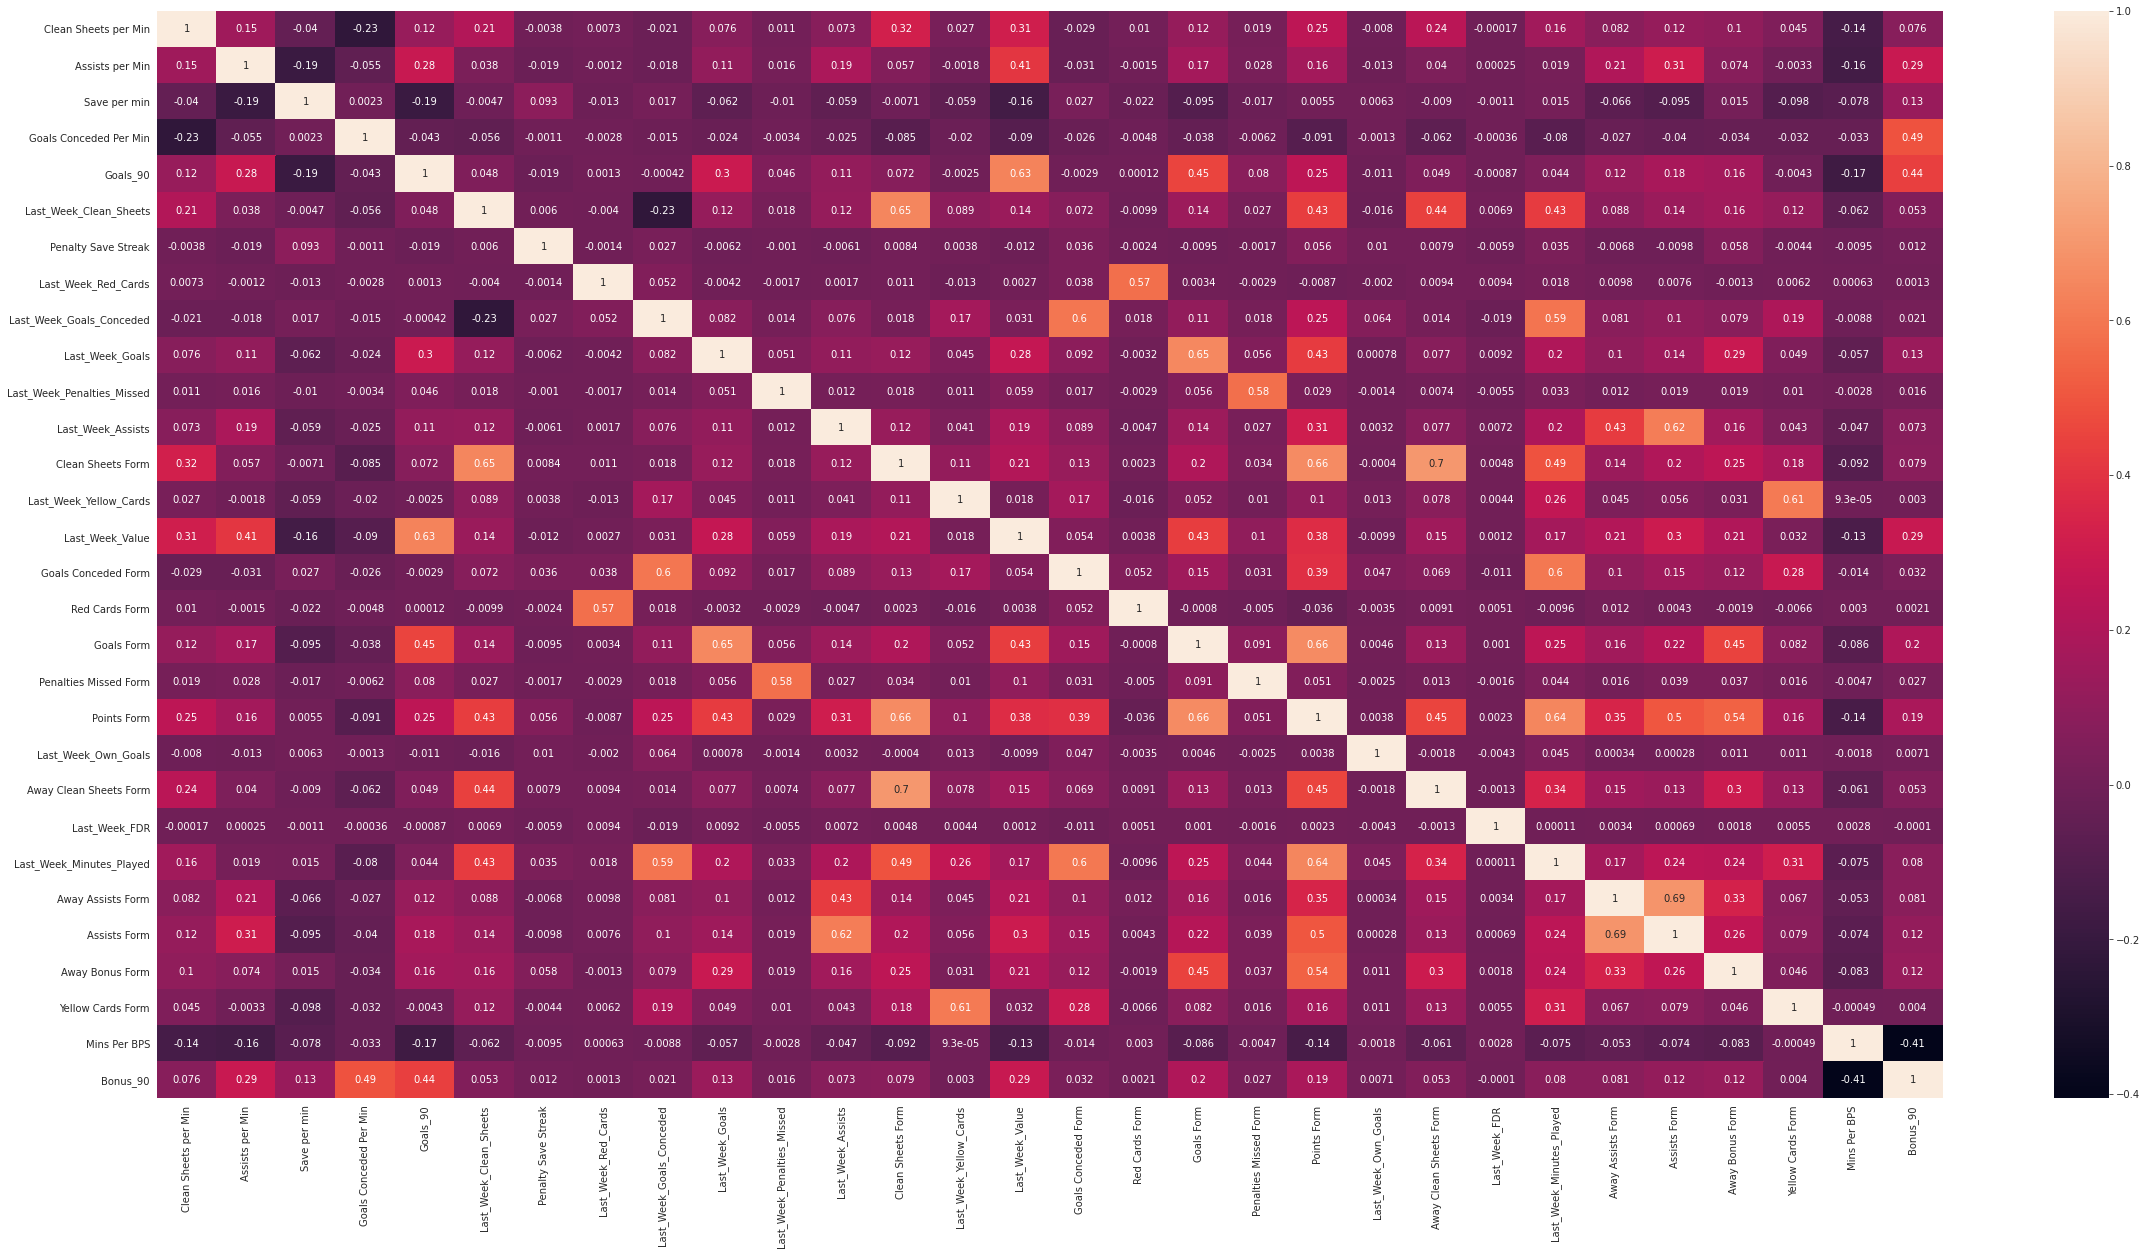

In [131]:
X1=gws1[['Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
y1=y.astype(int)
plt.figure(figsize=(40,20))
sns.heatmap(X1.corr(),annot=True)
# smote=SMOTE(sampling_strategy='all')
print(sum(y1==1))
print(sum(y1==2))
# print(sum(y_train==3))
# print(sum(y_train==4))
# print(X_train.shape)
# X_train,y_train=smote.fit_sample(X_train,y_train)
# print(sum(y_train==1))
# print(sum(y_train==2))
# print(sum(y_train==3))
# print(sum(y_train==4))
# print(X_train.shape)


In [132]:
X_train, X_test, y_train, y_test = train_test_split( X1, y1, test_size=0.20, random_state=140)
smote=SMOTE(sampling_strategy='all')
X_train,y_train=smote.fit_sample(X_train,y_train)
print(sum(y_train==1))
print(sum(y_train==2))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



52097
0


**Scaling the values**

In [133]:
# since we had a lot of attributes we decided the reduce it using PCA and scaled it
scaler= StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
# from sklearn.decomposition import PCA
# pca = PCA(0.90)
# pca.fit_transform(X_train)
# X_train=pca.transform(X_train)
# X_test=pca.transform(X_test)



**Hyper parameter tuning of logistic regression**

In [134]:
# #hyper parameter tuning
# model=LogisticRegression()
# solvers = ['newton-cg', 'lbfgs']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**Hyper Parameter tuning of KNN**

In [135]:
# List Hyperparameters that we want to tune.
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# #Create new KNN object
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(X,y)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

**Hyper parameter tuning of Extra Gradient Boosting**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 5
param_comb = 5

skf = RepeatedStratifiedKFold(n_splits=folds, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

Fitting 50 folds for each of 5 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 21.4min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 137.8min


In [137]:
  from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


In [151]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.8323484351061502
SCORE:
0.8101699861384694
SCORE:
0.8288465747428321
SCORE:
0.7962355001094331
SCORE:
0.8246151601371562
SCORE:
0.813817757350259
SCORE:
0.8009776026847596
SCORE:
0.825052892682571
SCORE:
0.7915663529583424
SCORE:
0.828554753045889
SCORE:
0.7953600350186036
SCORE:
0.8063033486539725
SCORE:
0.8270226891369373
SCORE:
0.8289195301670679
SCORE:
0.8276063325308237
SCORE:
0.8055737944116145
SCORE:
0.8210403443496024
SCORE:
0.794849347048953
SCORE:
0.8042605967753702
SCORE:
0.8270226891369373
SCORE:
0.8274604216823521
SCORE:
0.8276063325308237
SCORE:
0.8275333771065879
SCORE:
0.8302327278033121
SCORE:
0.8257094915006931
SCORE:
0.8293572627124827
SCORE:
0.8136718465017874
SCORE:
0.8272415554096447
SCORE:
0.8248340264098636
SCORE:
0.8188516816225286
SCORE:
0.8228642299554972
SCORE:
0.8303056832275479
SCORE:
0.8282629313489458
SCORE:
0.7739840957175166
SCORE:
0.8275333771065879
SCORE:
0.8332239001969797
SCORE:
0.8154957321076822
SCORE:
0.828554753045889
SCORE:
0.83278616

KeyboardInterrupt: ignored

**Fitting the model with Cross Validation to avoid overfitting**

In [140]:
print(best_hyperparams)

{'colsample_bytree': 0.5790072458383384, 'gamma': 6.105405070049148, 'max_depth': 18.0, 'min_child_weight': 1.0, 'reg_alpha': 40.0, 'reg_lambda': 0.3990451024324678}


In [152]:
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.utils import class_weight
# Observe how I imported Pipeline from IMBLEARN and not SKLEARN
from imblearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from imblearn.pipeline import Pipeline, make_pipeline

# kf = KFold(n_splits=5, random_state=42, shuffle=False)

# params = {
#     'n_estimators': [300],
#     'max_depth': [15,16,17],
#     'random_state': [20]
# }
# imba_pipeline = make_pipeline(SMOTE(random_state=42,sampling_strategy='all'), RandomForestClassifier( n_estimators=100,random_state=13,class_weight='balanced'))
# cross_val_score(imba_pipeline, X_train, y_train, scoring='accuracy', cv=kf)

# new_params = {'randomforestclassifier__' + key: params[key] for key in params}
# ovr = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='accuracy',
#                         return_train_score=True)
ovr=XGBClassifier(colsample_bytree=0.5790072458383384, gamma= 6.105405070049148, max_depth= 18, min_child_weight= 1.0, reg_alpha= 40.0, reg_lambda= 0.3990451024324678)
ovr.fit(X_train, y_train)

# This pipeline will resample the data and  
# pass the output to MultinomialNB
# pipe = Pipeline([('sampl', SMOTEENN()), 
#                  ('clf', LogisticRegression(max_iter=5000,class_weight='balanced'))])

# OVR will transform the `y` as you know and 
# then pass single label data to different copies of pipe 
# multiple times (as many labels in data)
# ovr = RandomForestClassifier()
# # ovr=SVC(decision_function_shape='ovr')
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# # evaluate model
# scores = cross_val_score(ovr, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# print(scores)
# # summarize performance
# print('Accuracy: %.3f' % np.mean(scores))
# ovr.fit(X_train, y_train)




AttributeError: ignored

In [507]:
# print(ovr.best_params_)
# print(ovr.best_score_)


{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__random_state': 20}
0.8097438252412985


In [375]:
# #training the model


# #model=RandomForestClassifier()
# #model=RandomForestRegressor()
# #model=KNeighborsClassifier(leaf_size=1,p=2,n_neighbors=8)
# #model=LogisticRegression(C=10,solver='newton-cg',penalty='l2',class_weight='balanced')
# # model=XGBClassifier(scale_pos_weight=40,base_score=0.5, booster='gbtree', colsample_bylevel=1,
# #               colsample_bynode=1, colsample_bytree=1, gamma=0,
# #               learning_rate=0.1, max_delta_step=0, max_depth=6,
# #               min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
# #               nthread=4, objective='binary:logistic', random_state=0,
# #               reg_alpha=0, reg_lambda=1, seed=42,
# #               silent=None, subsample=1, verbosity=1)
# #model=DecisionTreeClassifier()
# #model=Lasso()
# #model=Ridge()
# #model=LinearRegression()
# #model=sm.OLS(X_train,y_train)
# #model=SGDRegressor(eta0=0.0001)
# model=LogisticRegression(max_iter=5000,class_weight='balanced')
# #model1 = BalancedRandomForestClassifier()
# #model1 = RandomForestClassifier(class_weight='balanced')
# model1= OneVsRestClassifier(model)


# # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# # # evaluate model
# # scores = cross_val_score(model1, X_train1, y_train1, scoring='accuracy', cv=cv, n_jobs=-1)
# # # summarize performance
# # print('Mean ROC AUC: %.3f' % np.mean(scores))

# model1.fit(X_train1, y_train)

**Predicting output for testing set**

In [149]:
from sklearn.metrics import roc_curve
#predicting the values 
# predict=model1.predict(X_test)
predict=clf.predict(X_test)
predictp=clf.predict_proba(X_test)


NameError: ignored

**Storing the output as well as the probabilities for each prediction in a dataframe**

In [145]:
# predict = model.predict(X_test)
df1=pd.DataFrame({'Actual':y_test,'Predicted':predict})
a=df1[1]=predictp[:,0].round(decimals=2)
b=df1[2]=predictp[:,1].round(decimals=2)
# df1[3]=predictp[:,2].round(decimals=2)
# df1[4]=predictp[:,3].round(decimals=2)

df1.head(40)


,Actual,Predicted,1,2
29875,0,0,0.99,0.01
8384,0,0,0.82,0.18
20060,0,0,0.93,0.07
5209,0,0,0.96,0.04
50225,0,0,0.93,0.07
77252,0,0,0.73,0.27
8097,0,0,1.00,0.00
59766,0,0,1.00,0.00
3049,0,0,0.98,0.02
53543,0,0,0.94,0.06


**Performance Metrics of the Model**

In [147]:
from sklearn.metrics import classification_report, confusion_matrix,auc, roc_auc_score
print(classification_report(y_test,predict))
print(balanced_accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print( roc_auc_score(y_test,a) )
print( roc_auc_score(y_test,b) )




              precision    recall  f1-score   support

           0       0.95      1.00      0.97     13015
           1       0.27      0.01      0.01       692

    accuracy                           0.95     13707
   macro avg       0.61      0.50      0.49     13707
weighted avg       0.92      0.95      0.93     13707

0.5024675840903893
[[13004    11]
 [  688     4]]
0.18217002835767535
0.8178299716423247


In [148]:
ovr.score(X_test,y_test)



0.9490041584591814


**Validation on unseen data( Not yet Ready)**

In [380]:
x=pd.read_csv('/content/drive/My Drive/combined_2016-2020-1.csv',encoding = "ISO-8859-1")

x.tail(200)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
88958,Steve Cook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15T17:00:00Z,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150
88959,Fabio Henrique Tavares,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15T19:15:00Z,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150
88960,Anthony Driscoll-Glennon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15T17:00:00Z,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
88961,David Martin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-17T19:00:00Z,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
88962,Danny Ings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-16T19:15:00Z,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
88963,Tom Trybull,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-14T19:15:00Z,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150
88964,James Maddison,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-16T17:00:00Z,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
88965,CeÌsar Azpilicueta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-14T19:15:00Z,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150
88966,Taylor Perry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15T17:00:00Z,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150
88967,Maya Yoshida,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-16T19:15:00Z,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150


In [381]:
x=x.astype({'was_home':str})

In [382]:
x = x.assign(id=(x['name']).astype('category').cat.codes)


In [383]:
x.rename(columns={'opponent_team':'fdr'},inplace=True)


In [384]:
x['fdr']=x['fdr'].apply(fd).astype(float)


In [385]:
x['kickoff_time']=pd.to_datetime(x['kickoff_time'])

In [386]:
x['kickoff_time'] = x.kickoff_time.dt.hour

In [387]:
x['kickoff_time']=x['kickoff_time'].apply(time).astype(float)
x.tail(20)

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id
89138,Neco Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,1063
89139,Abd-Al-Ali Morakinyo Olaposi Koiki,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,8
89140,John Ruddy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,704
89141,Oriol Romeu Vidal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1099
89142,Aaron Wan-Bissaka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,7
89143,JoseÌ Ignacio Peleteiro Romallo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,749
89144,Ryan Fraser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,1214
89145,Robert Elliot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1183
89146,Craig Cathcart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,291
89147,Kevin Danso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,814


In [388]:
x['home']=x['was_home'].apply(was_home)
x.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id,home
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,454.0,10.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,14023.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,55.0,False,0.0,1,1,Away
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,142.0,3.0,0.0,0.0,0.9,8.2,1.0,15.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,13918.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,60.0,True,0.0,1,2,Home
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,16.0,8.0,3.0,0.0,3.0,2.2,1.0,60.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,163170.0,4.0,3.0,23.0,2.0,0.0,0.0,0.0,80.0,True,0.0,1,5,Home
3,Abdoulaye Doucouré,0.0,0.0,0.0,0.0,0.0,482.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1051.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,50.0,False,0.0,1,12,Away
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,80.0,10.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1243.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,55.0,True,0.0,1,13,Home


In [389]:
x['Away Points'] = np.where(x['home'] == 'Home', x['total_points'] * 0,x['total_points'])
x['Home Points'] = np.where(x['home'] == 'Away', x['total_points'] * 0,x['total_points'])

x['Away Influence'] = np.where(x['home'] == 'Home', x['influence'] * 0,x['influence'])
x['Home Influence'] = np.where(x['home'] == 'Away', x['influence'] * 0,x['influence'])

x['Away Goals'] = np.where(x['home'] == 'Home', x['goals_scored'] * 0,x['goals_scored'])
x['Home Goals'] = np.where(x['home'] == 'Away', x['goals_scored'] * 0,x['goals_scored'])

x['Away Saves'] = np.where(x['home'] == 'Home', x['saves'] * 0,x['saves'])
x['Home Saves'] = np.where(x['home'] == 'Away', x['saves'] * 0,x['saves'])

x['Away Creativity'] = np.where(x['home'] == 'Home', x['creativity'] * 0,x['creativity'])
x['Home Creativity'] = np.where(x['home'] == 'Away', x['creativity'] * 0,x['creativity'])

x['Away ICT'] = np.where(x['home'] == 'Home', x['ict_index'] * 0,x['ict_index'])
x['Home ICT'] = np.where(x['home'] == 'Away', x['ict_index'] * 0,x['ict_index'])

x['Away Bonus'] = np.where(x['home'] == 'Home', x['bonus'] * 0,x['bonus'])
x['Home Bonus'] = np.where(x['home'] == 'Away', x['bonus'] * 0,x['bonus'])

x['Away Clean Sheets'] = np.where(x['home'] == 'Home', x['clean_sheets'] * 0,x['clean_sheets'])
x['Home Clean Sheets'] = np.where(x['home'] == 'Away', x['clean_sheets'] * 0,x['clean_sheets'])

x['Away Penalties Saved'] = np.where(x['home'] == 'Home', x['penalties_saved'] * 0,x['penalties_saved'])
x['Home Penalties Saved'] = np.where(x['home'] == 'Away', x['penalties_saved'] * 0,x['penalties_saved'])

x['Away Goals Conceded'] = np.where(x['home'] == 'Home', x['goals_conceded'] * 0,x['goals_conceded'])
x['Home Goals Conceded'] = np.where(x['home'] == 'Away', x['goals_conceded'] * 0,x['goals_conceded'])

x['Away Assists'] = np.where(x['home'] == 'Home', x['assists'] * 0,x['assists'])
x['Home Assists'] = np.where(x['home'] == 'Away', x['assists'] * 0,x['assists'])

x.tail(100)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists
89058,Danny Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,331,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89059,Ryan Giles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,1216,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89060,Moussa Djenepo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,1035,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89061,Alex Iwobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,60,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89062,Mason Greenwood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,951,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89063,Christian Fuchs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,150,267,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89064,Mark Duffy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,930,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89065,Marco Stiepermann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,919,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89066,Todd Cantwell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,1335,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89067,Matteo Darmian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,150,969,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [390]:
x.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [391]:
x['value']=x['value']*0.1


In [392]:
x['points']=x['total_points'].apply(points)
x.tail(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points
89058,Danny Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,331,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89059,Ryan Giles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1216,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89060,Moussa Djenepo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1035,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89061,Alex Iwobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,60,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89062,Mason Greenwood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,951,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89063,Christian Fuchs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,267,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89064,Mark Duffy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,930,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89065,Marco Stiepermann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,919,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89066,Todd Cantwell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1335,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
89067,Matteo Darmian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,969,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [393]:
home=pd.get_dummies(x['home'])
x=pd.concat([x,home],axis=1)
x.head(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Away,Home
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,14023.0,0.0,0.0,5.5,0.0,1,1,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,0.0,0.0,0.9,8.2,1.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,13918.0,0.0,1.0,6.0,0.0,1,2,Home,0.0,1.0,0.0,8.2,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,3.0,0.0,3.0,2.2,1.0,60.0,1.0,0.0,0.0,0.0,0.0,0.0,163170.0,23.0,2.0,8.0,0.0,1,5,Home,0.0,2.0,0.0,2.2,0.0,0.0,0.0,0.0,0.0,4.9,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1,0,1
3,Abdoulaye Doucouré,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1051.0,0.0,0.0,5.0,0.0,1,12,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1243.0,0.0,0.0,5.5,0.0,1,13,Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
5,Abel Hernández,1.0,0.0,10.0,0.0,12.2,1.0,0.0,5.7,14.4,0.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,26039.0,30.0,5.0,6.0,0.0,1,14,Home,0.0,5.0,0.0,14.4,0.0,0.0,0.0,0.0,0.0,12.2,0.0,5.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0,1
6,Adama Diomande,0.0,2.0,29.0,0.0,16.8,1.0,1.0,10.7,45.2,0.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,38151.0,45.0,8.0,4.5,0.0,1,31,Home,0.0,8.0,0.0,45.2,0.0,1.0,0.0,0.0,0.0,16.8,0.0,10.7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0,1
7,Adam Clayton,0.0,0.0,6.0,0.0,2.2,1.0,0.0,1.4,3.2,1.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,17663.0,9.0,2.0,4.5,0.0,1,19,Home,0.0,2.0,0.0,3.2,0.0,0.0,0.0,0.0,0.0,2.2,0.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1
8,Adam Federici,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4315.0,0.0,0.0,4.5,0.0,1,20,Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
9,Adam Forshaw,0.0,0.0,3.0,0.0,1.3,1.0,0.0,0.3,2.0,1.0,69.0,1.0,0.0,0.0,0.0,0.0,0.0,2723.0,0.0,1.0,4.5,1.0,1,21,Home,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.3,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1


In [394]:
x['Last_Week_Points'] = x.groupby(['id'])['points'].shift().astype(float)
# x['Last_2_Week_Points'] = x.groupby(['id'])['points'].shift(2).astype(float)
#x['Last_3_Week_Points'] = x.groupby(['id'])['total_points'].shift(3).astype(float)
#x['Last_4_Week_Points'] = x.groupby(['id'])['total_points'].shift(4).astype(float)



x['Last_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift().astype(float)
# x['Last_2_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(2).astype(float)
#x['Last_3_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(3).astype(float)


x['Last_Week_ICT'] = x.groupby(['id'])['ict_index'].shift().astype(float)
x['Last_2_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(2).astype(float)
# #x['Last_3_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(3).astype(float)


x['Last_Week_BPS'] = x.groupby(['id'])['bps'].shift().astype(float)
x['Last_2_Week_BPS'] = x.groupby(['id'])['bps'].shift(2).astype(float)
#x['Last_3_Week_BPS'] = x.groupby(['id'])['bps'].shift(3).astype(float)


x['Last_Week_Assists'] = x.groupby(['id'])['assists'].shift().astype(float)
x['Last_2_Week_Assists'] = x.groupby(['id'])['assists'].shift(2).astype(float)
#x['Last_3_Week_Assists'] = x.groupby(['id'])['assists'].shift(3).astype(float)


x['Last_Week_Bonus'] = x.groupby(['id'])['bonus'].shift().astype(float)
x['Last_2_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(2).astype(float)
#x['Last_3_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(3).astype(float)


x['Last_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift().astype(float)
x['Last_2_Week_Penalties_Saved'] =x.groupby(['id'])['penalties_saved'].shift(2).astype(float)


x['Last_Week_Influence'] = x.groupby(['id'])['influence'].shift().astype(float)
x['Last_2_Week_Influence'] = x.groupby(['id'])['influence'].shift(2).astype(float)
#x['Last_3_Week_Influence'] = x.groupby(['id'])['influence'].shift(3).astype(float)


x['Last_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift().astype(float)
x['Last_2_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(2).astype(float)
#x['Last_3_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(3).astype(float)


x['Last_Week_Threat'] = x.groupby(['id'])['threat'].shift().astype(float)
x['Last_2_Week_Threat'] = x.groupby(['id'])['threat'].shift(2).astype(float)
# #x['Last_3_Week_Threat'] = x.groupby(['id'])['threat'].shift(3).astype(float)


x['Last_Week_Selected'] = x.groupby(['id'])['selected'].shift().astype(float)
x['Last_2_Week_Selected'] = x.groupby(['id'])['selected'].shift(2).astype(float)
#x['Last_3_Week_Selected'] = x.groupby(['id'])['selected'].shift(3).astype(float)


x['Last_Week_Value'] = x.groupby(['id'])['value'].shift().astype(float)
x['Last_2_Week_Value'] = x.groupby(['id'])['value'].shift(2).astype(float)
# x['Last_3_Week_Value'] = x.groupby(['id'])['value'].shift(3).astype(float)


x['Last_Week_Creativity'] = x.groupby(['id'])['creativity'].shift().astype(float)
x['Last_2_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(2).astype(float)
# #x['Last_3_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(3).astype(float)



x['Last_Week_FDR'] = x.groupby(['id'])['fdr'].shift().astype(float).astype(float)
x['Last_2_Week_FDR'] = x.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
x['Last_3_Week_FDR'] = x.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


x['Last_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift().astype(float)
x['Last_2_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#x['Last_3_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(3).astype(float)


x['Last_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift().astype(float)
x['Last_2_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#x['Last_3_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# x['Last_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift().astype(float)
# x['Last_2_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# x['Last_3_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(3).astype(float)


x['Last_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift().astype(float)
x['Last_2_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(2).astype(float)
# x['Last_3_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(3).astype(float)

x['Last_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift().astype(float)

x['Last_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift().astype(float)
x['Last_2_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# x['Last_3_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift(3).astype(float)


x['Last_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift().astype(float)
x['Last_2_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(2).astype(float)
# x['Last_3_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(3).astype(float)


x['Last_Week_Saves'] = x.groupby(['id'])['saves'].shift()
x['Last_2_Week_Saves'] = x.groupby(['id'])['saves'].shift(2)
#x['Last_3_Week_Saves'] = x.groupby(['id'])['saves'].shift(3)


x['Last_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift()
x['Last_2_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(2)
# x['Last_3_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(3)


# x['Last_Week_Home'] = x.groupby(['id'])['home'].shift()
# x['Last_2_Week_Home'] = x.groupby(['id'])['home'].shift(2)
# x['Last_3_Week_Home'] = x.groupby(['id'])['home'].shift(3)
#feature engineered a number of variables to better define the dependent variable
window=3

hpm =(x.groupby('id',as_index=False)['Home Points'].rolling(window=window).sum()/window).shift(1)
x["Home Points Form"] = hpm.reset_index(level=0, drop=True)

apm =(x.groupby('id',as_index=False)['Away Points'].rolling(window=window).sum()/window).shift(1)
x["Away Points Form"] = apm.reset_index(level=0, drop=True)

ppm =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =x.groupby('id',as_index=False)['value'].expanding().sum()/x.groupby('id',as_index=False)['total_points'].expanding().sum()*90
x["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['assists'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Assists per Min"] = apm.reset_index(level=0, drop=True)

gpm =x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =x.groupby('id',as_index=False)['bonus'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90
x["Bonus_90"] = ipm.reset_index(level=0, drop=True)

ih =(x.groupby('id',as_index=False)['Home Influence'].rolling(window=window).sum()/window).shift(1)
x["Home Influence Form"] = ih.reset_index(level=0, drop=True)

ah =(x.groupby('id',as_index=False)['Away Influence'].rolling(window=window).sum()/window).shift(1)
x["Away Influence Form"] = ah.reset_index(level=0, drop=True)

hg =(x.groupby('id',as_index=False)['Home Goals'].rolling(window=window).sum()/window).shift(1)
x["Home Goals Form"] = hg.reset_index(level=0, drop=True)

ag =(x.groupby('id',as_index=False)['Away Goals'].rolling(window=window).sum()/window).shift(1)
x["Away Goals Form"] = hg.reset_index(level=0, drop=True)


gs =(x.groupby('id',as_index=False)['goals_scored'].rolling(window=window).sum()/window).shift(1)
x["Goals Form"] = gs.reset_index(level=0, drop=True)

ag =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Clean Sheets per Min"] = ag.reset_index(level=0, drop=True)

cs =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Points Per Min"] = cs.reset_index(level=0, drop=True)

gc =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Goals Conceded Per Min"] = gc.reset_index(level=0, drop=True)

s =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()
x["Save per min"] = s.reset_index(level=0, drop=True)

sh =(x.groupby('id',as_index=False)['Home Saves'].rolling(window=window).sum()/window).shift(1)
x["Home Saves Form"] = sh.reset_index(level=0, drop=True)

sa =(x.groupby('id',as_index=False)['Away Saves'].rolling(window=window).sum()/window).shift(1)
x["Away Saves Form"] = sa.reset_index(level=0, drop=True)

sf =(x.groupby('id',as_index=False)['saves'].rolling(window=window).sum()/window).shift(1)
x["Saves Form"] = sf.reset_index(level=0, drop=True)

mp =(x.groupby('id',as_index=False)['minutes'].rolling(window=window).sum()/window).shift(1)
x["Minutes Form"] = mp.reset_index(level=0, drop=True)

ch =(x.groupby('id',as_index=False)['Home Creativity'].rolling(window=window).sum()/window).shift(1)
x["Home Creativity Form"] = ch.reset_index(level=0, drop=True)

ca =(x.groupby('id',as_index=False)['Away Creativity'].rolling(window=window).sum()/window).shift(1)
x["Away Creativity Form"] = ca.reset_index(level=0, drop=True)

csh =(x.groupby('id',as_index=False)['Home Clean Sheets'].rolling(window=window).sum()/window).shift(1)
x[" Home Clean Sheets Form"] = csh.reset_index(level=0, drop=True)

csa =(x.groupby('id',as_index=False)['Away Clean Sheets'].rolling(window=window).sum()/window).shift(1)
x["Away Clean Sheets Form"] = csa.reset_index(level=0, drop=True)

cs =(x.groupby('id',as_index=False)['clean_sheets'].rolling(window=window).sum()/window).shift(1)
x["Clean Sheets Form"] = cs.reset_index(level=0, drop=True)

bph =(x.groupby('id',as_index=False)['Home Bonus'].rolling(window=window).sum()/window).shift(1)
x['Home Bonus Form'] = bph.reset_index(level=0, drop=True)

bp =(x.groupby('id',as_index=False)['bonus'].rolling(window=window).sum()/window).shift(1)
x['Bonus Form'] = bp.reset_index(level=0, drop=True)

bpa =(x.groupby('id',as_index=False)['Away Bonus'].rolling(window=window).sum()/window).shift(1)
x["Away Bonus Form"] = bpa.reset_index(level=0, drop=True)

icth =(x.groupby('id',as_index=False)['Home ICT'].rolling(window=window).sum()/window).shift(1)
x['Home ICT Form'] = icth.reset_index(level=0, drop=True)

icta =(x.groupby('id',as_index=False)['Away ICT'].rolling(window=window).sum()/window).shift(1)
x["Away ICT Form"] = icta.reset_index(level=0, drop=True)


ict =(x.groupby('id',as_index=False)['ict_index'].rolling(window=window).sum()/window).shift(1)
x["ICT Form"] = ict.reset_index(level=0, drop=True)

ah =(x.groupby('id',as_index=False)['Home Assists'].rolling(window=window).sum()/window).shift(1)
x['Home Assists Form'] = ah.reset_index(level=0, drop=True)

aa =(x.groupby('id',as_index=False)['Away Assists'].rolling(window=window).sum()/window).shift(1)
x["Away Assists Form"] = aa.reset_index(level=0, drop=True)

ast =(x.groupby('id',as_index=False)['assists'].rolling(window=window).sum()/window).shift(1)
x["Assists Form"] = ast.reset_index(level=0, drop=True)

# ms =x.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/x.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# x["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['bps'].expanding().sum()
x["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =(x.groupby('id',as_index=False)['Away Goals Conceded'].rolling(window=5).sum()/window).shift(1)
x["Away Goals Concecded Form"] = gca.reset_index(level=0, drop=True)

gch =(x.groupby('id',as_index=False)['Home Goals Conceded'].rolling(window=5).sum()/window).shift(1)
x["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gc =(x.groupby('id',as_index=False)['goals_conceded'].rolling(window=5).sum()/window).shift(1)
x["Goals Conceded Form"] = gc.reset_index(level=0, drop=True)

gcm =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()
x["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)

tp =(x.groupby('id',as_index=False)['total_points'].rolling(window=window).sum()/window).shift(1)
x["Points Form"] = tp.reset_index(level=0, drop=True)

pm =(x.groupby('id',as_index=False)['penalties_missed'].rolling(window=window).sum()/window).shift(1)
x["Penalties Missed Form"] = pm.reset_index(level=0, drop=True)

yc =(x.groupby('id',as_index=False)['yellow_cards'].rolling(window=window).sum()/window).shift(1)
x["Yellow Cards Form"] = yc.reset_index(level=0, drop=True)

rc =(x.groupby('id',as_index=False)['red_cards'].rolling(window=window).sum()/window).shift(1)
x["Red Cards Form"] = rc.reset_index(level=0, drop=True)
# ms =x1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/x1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# x1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['bps'].expanding().sum()
x["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum()
x["Goals Concecded Away"] = gca.reset_index(level=0, drop=True)

gch =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum()
x["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gcm =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()
x["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)


x.head(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,...,Goals_90,Influence_90,Bonus_90,Home Influence Form,Away Influence Form,Home Goals Form,Away Goals Form,Goals Form,Clean Sheets per Min,Points Per Min,Goals Conceded Per Min,Save per min,Home Saves Form,Away Saves Form,Saves Form,Minutes Form,Home Creativity Form,Away Creativity Form,Home Clean Sheets Form,Away Clean Sheets Form,Clean Sheets Form,Home Bonus Form,Bonus Form,Away Bonus Form,Home ICT Form,Away ICT Form,ICT Form,Home Assists Form,Away Assists Form,Assists Form,Mins Per BPS,Away Goals Concecded Form,Goals Conceded Home,Goals Conceded Form,Mins per Goals Conceded,Points Form,Penalties Missed Form,Yellow Cards Form,Red Cards Form,Goals Concecded Away
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,14023.0,0.0,0.0,5.5,0.0,1,1,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,0.0,0.0,0.9,8.2,1.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,13918.0,0.0,1.0,6.0,0.0,1,2,Home,0.0,1.0,0.0,8.2,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.9,0.0,0.0,...,0.0000,49.200000,49.200000,NaN,NaN,NaN,NaN,NaN,0.000000,0.066667,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000,NaN,0.0,NaN,inf,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,3.0,0.0,3.0,2.2,1.0,60.0,1.0,0.0,0.0,0.0,0.0,0.0,163170.0,23.0,2.0,8.0,0.0,1,5,Home,0.0,2.0,0.0,2.2,0.0,0.0,0.0,0.0,0.0,4.9,0.0,3.0,0.0,0.0,...,0.0000,3.300000,3.300000,NaN,NaN,NaN,NaN,NaN,0.000000,0.033333,0.050000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,NaN,3.0,NaN,20.000000,NaN,NaN,NaN,NaN,inf
3,Abdoulaye Doucouré,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1051.0,0.0,0.0,5.0,0.0,1,12,Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,3.200000e+00,6.266667e+00,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,90.000000,2.633333e+00,5.666667e-01,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.833333e+00,7.000000e-01,2.533333e+00,0.0,0.000000,0.000000,NaN,1.333333,NaN,3.000000,NaN,2.000000,0.0,0.000000,0.0,0.0
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1243.0,0.0,0.0,5.5,0.0,1,13,Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,8.933333e+00,4.200000e+00,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,90.000000,1.296667e+01,8.100000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.733333e+00,2.033333e+00,5.766667e+00,0.0,0.000000,0.000000,NaN,1.333333,0.0,3.666667,NaN,1.666667,0.0,0.333333,0.0,NaN
5,Abel Hernández,1.0,0.0,10.0,0.0,12.2,1.0,0.0,5.7,14.4,0.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,26039.0,30.0,5.0,6.0,0.0,1,14,Home,0.0,5.0,0.0,14.4,0.0,0.0,0.0,0.0,0.0,12.2,0.0,5.7,0.0,0.0,...,0.0000,14.400000,14.400000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000,0.055556,0.011111,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,9.000000,0.000000,1.0,0.000000,90.000000,0.000000,0.0,0.000000,0.0,inf
6,Adama Diomande,0.0,2.0,29.0,0.0,16.8,1.0,1.0,10.7,45.2,0.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,38151.0,45.0,8.0,4.5,0.0,1,31,Home,0.0,8.0,0.0,45.2,0.0,1.0,0.0,0.0,0.0,16.8,0.0,10.7,0.0,2.0,...,1.0000,45.200000,45.200000,5.921189e-16,0.000000e+00,0.0,0.0,0.000000,0.000000,0.088889,0.011111,0.000000,0.0,0.0,0.0,0.333333,-1.184238e-15,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000

In [395]:
x=x.groupby('id').apply(f)
x=x.groupby('id').apply(f2)
x=x.groupby('id').apply(f3)

In [396]:
x1=x[x['gw']==150]
x1.head(40)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,gw,id,home,Away Points,Home Points,Away Influence,Home Influence,Away Goals,Home Goals,Away Saves,Home Saves,Away Creativity,Home Creativity,Away ICT,Home ICT,Away Bonus,Home Bonus,...,Home Influence Form,Away Influence Form,Home Goals Form,Away Goals Form,Goals Form,Clean Sheets per Min,Points Per Min,Goals Conceded Per Min,Save per min,Home Saves Form,Away Saves Form,Saves Form,Minutes Form,Home Creativity Form,Away Creativity Form,Home Clean Sheets Form,Away Clean Sheets Form,Clean Sheets Form,Home Bonus Form,Bonus Form,Away Bonus Form,Home ICT Form,Away ICT Form,ICT Form,Home Assists Form,Away Assists Form,Assists Form,Mins Per BPS,Away Goals Concecded Form,Goals Conceded Home,Goals Conceded Form,Mins per Goals Conceded,Points Form,Penalties Missed Form,Yellow Cards Form,Red Cards Form,Goals Concecded Away,Goal Streak,Clean Sheet Streak,Penalty Save Streak
88504,Charlie Austin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,248,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.217249e-15,-5.921189e-16,0.000000,0.000000,0.000000,0.005123,0.061475,0.013661,0.000000,0.0,0.0,0.0,0.000000,-2.479498e-15,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.053113e-16,-5.921189e-16,3.053113e-16,0.000000,0.000000,0.000000,5.323636,0.000000,0.533333,0.000000,73.200000,0.000000,0.0,0.000000,0.0,0.533333,0.0,0.0,0.0
88505,Mark Noble,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,932,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.184238e-15,1.620000e+01,0.000000,0.000000,0.000000,0.003057,0.036787,0.016549,0.000000,0.0,0.0,0.0,36.333333,2.368476e-15,3.886667e+01,0.000000,0.333333,0.333333,0.000000,0.333333,0.333333,-1.776357e-15,5.700000e+00,5.700000e+00,0.000000,0.333333,0.333333,5.393405,0.666667,2.093333,0.666667,60.426752,2.666667,0.0,0.000000,0.0,2.093333,0.0,1.0,0.0
88506,Simon Mignolet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1278,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.960595e-15,-2.664535e-15,0.000000,0.000000,0.000000,0.003783,0.041844,0.012766,0.020804,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.960595e-16,-3.330669e-16,4.070818e-16,0.000000,0.000000,0.000000,5.065868,0.000000,0.720000,0.000000,78.333333,0.000000,0.0,0.000000,0.0,0.720000,0.0,0.0,0.0
88507,Bruno Miguel Borges Fernandes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,218,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.500000e+01,1.986667e+01,0.333333,0.333333,0.666667,0.007592,0.107375,0.005423,0.000000,0.0,0.0,0.0,81.000000,3.343333e+01,1.496667e+01,0.000000,0.333333,0.333333,0.666667,1.666667,1.000000,7.966667e+00,4.333333e+00,1.230000e+01,1.000000,0.333333,1.333333,2.917722,0.000000,0.833333,1.000000,184.400000,11.333333,0.0,0.000000,0.0,0.833333,0.0,0.0,0.0
88508,Djibril SidibeÌ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,389,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88509,Victor LindeloÌf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150,1367,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.881784e-16,1.000000e+00,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.333333,0.000000e+00,3.833333e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.885781e-16,5.666667e-01,5.666667e-01,0.000000,0

In [397]:

x_test=x1[['Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form', 'Saves Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
x_test=x_test.replace([np.inf, -np.inf], np.nan)
x_test=x_test.dropna()
x_testf=x1[['name','Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form', 'Saves Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
x_testf=x_testf.replace([np.inf, -np.inf], np.nan)
x_testf=x_testf.dropna()
x_test.head(100)


,Clean Sheets per Min,Assists per Min,Save per min,Goals Conceded Per Min,Goals_90,Last_Week_Clean_Sheets,Penalty Save Streak,Last_Week_Red_Cards,Last_Week_Goals_Conceded,Last_Week_Goals,Last_Week_Penalties_Missed,Last_Week_Assists,Clean Sheets Form,Last_Week_Yellow_Cards,Last_Week_Value,Goals Conceded Form,Red Cards Form,Goals Form,Penalties Missed Form,Points Form,Last_Week_Own_Goals,Away Clean Sheets Form,Last_Week_FDR,Last_Week_Minutes_Played,Away Assists Form,Assists Form,Saves Form,Away Bonus Form,Yellow Cards Form,Mins Per BPS,Bonus_90
88504,0.005123,0.001366,0.000000,0.013661,0.461066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,6.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.323636,22.604508
88505,0.003057,0.000843,0.000000,0.016549,0.151787,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.0,4.9,0.666667,0.0,0.000000,0.0,2.666667,0.0,0.333333,1.0,76.0,0.333333,0.333333,0.000000,0.333333,0.000000,5.393405,17.795088
88506,0.003783,0.000000,0.020804,0.012766,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.065868,15.791489
88507,0.007592,0.007592,0.000000,0.005423,0.683297,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333,0.0,9.0,1.000000,0.0,0.666667,0.0,11.333333,0.0,0.333333,2.0,83.0,0.333333,1.333333,0.000000,1.000000,0.000000,2.917722,48.201735
88510,0.003451,0.000157,0.000000,0.014431,0.098824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,5.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.989362,27.947294
88511,0.004934,0.003243,0.000000,0.010856,0.494854,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.333333,0.0,8.3,1.333333,0.0,0.666667,0.0,11.000000,0.0,0.333333,2.0,90.0,0.333333,1.333333,0.000000,0.000000,0.000000,4.469439,28.310729
88512,0.001821,0.000911,0.000000,0.021858,0.081967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.7,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8.255639,12.688525
88513,0.000000,0.000000,0.000000,0.035714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.9,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,17.142857
88514,0.003156,0.000493,0.000000,0.015486,0.239692,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.000000,1.0,6.7,3.333333,0.0,0.000000,0.0,1.333333,0.0,0.000000,3.0,74.0,0.000000,0.000000,0.000000,0.000000,0.666667,5.318993,22.916354
88516,0.000000,0.000000,0.000000,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,9.600000,4.406250


In [398]:
x_test1=scaler.transform(x_test)
predict1=ovr.predict(x_test1)
predict1

array([1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2,

In [399]:
predict1=pd.DataFrame(predict1)
predict1.head(100)
df1 = pd.concat([x_testf.reset_index(drop='Tru‌​e'),predict1.reset_index(drop='Tru‌​e')],axis=1)
df1.head(100)


,name,Clean Sheets per Min,Assists per Min,Save per min,Goals Conceded Per Min,Goals_90,Last_Week_Clean_Sheets,Penalty Save Streak,Last_Week_Red_Cards,Last_Week_Goals_Conceded,Last_Week_Goals,Last_Week_Penalties_Missed,Last_Week_Assists,Clean Sheets Form,Last_Week_Yellow_Cards,Last_Week_Value,Goals Conceded Form,Red Cards Form,Goals Form,Penalties Missed Form,Points Form,Last_Week_Own_Goals,Away Clean Sheets Form,Last_Week_FDR,Last_Week_Minutes_Played,Away Assists Form,Assists Form,Saves Form,Away Bonus Form,Yellow Cards Form,Mins Per BPS,Bonus_90,0
0,Charlie Austin,0.005123,0.001366,0.000000,0.013661,0.461066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,6.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.323636,22.604508,1
1,Mark Noble,0.003057,0.000843,0.000000,0.016549,0.151787,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.0,4.9,0.666667,0.0,0.000000,0.0,2.666667,0.0,0.333333,1.0,76.0,0.333333,0.333333,0.000000,0.333333,0.000000,5.393405,17.795088,2
2,Simon Mignolet,0.003783,0.000000,0.020804,0.012766,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.065868,15.791489,1
3,Bruno Miguel Borges Fernandes,0.007592,0.007592,0.000000,0.005423,0.683297,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333,0.0,9.0,1.000000,0.0,0.666667,0.0,11.333333,0.0,0.333333,2.0,83.0,0.333333,1.333333,0.000000,1.000000,0.000000,2.917722,48.201735,2
4,Laurent Koscielny,0.003451,0.000157,0.000000,0.014431,0.098824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,5.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.989362,27.947294,1
5,Anthony Martial,0.004934,0.003243,0.000000,0.010856,0.494854,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.333333,0.0,8.3,1.333333,0.0,0.666667,0.0,11.000000,0.0,0.333333,2.0,90.0,0.333333,1.333333,0.000000,0.000000,0.000000,4.469439,28.310729,2
6,Isaac Success Ajayi,0.001821,0.000911,0.000000,0.021858,0.081967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.7,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8.255639,12.688525,1
7,Marc Navarro,0.000000,0.000000,0.000000,0.035714,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.9,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,17.142857,1
8,Luka Milivojevic,0.003156,0.000493,0.000000,0.015486,0.239692,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.000000,1.0,6.7,3.333333,0.0,0.000000,0.0,1.333333,0.0,0.000000,3.0,74.0,0.000000,0.000000,0.000000,0.000000,0.666667,5.318993,22.916354,2
9,Beni Baningime,0.000000,0.000000,0.000000,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,9.600000,4.406250,1


In [400]:
df1.to_csv('/content/drive/My Drive/29.csv')